# **IRTM Text Mining Project: Song Genre Classification**
### Author: Matei Bejan, Group: 507

## Download and Import Necessary Libraries

Connect to Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download all necessary text processing NLTK packages.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Install all libraries needed for the **Create Lyrics-Metadata Dataset**. The usage of the downloaded libraries is as follows:

1. `pyphen` - split words into syllables.
2. `pronouncing` - retrieves the phonetic spelling of words as per the CMU Pronouncing Dictionary.
3. `langdetect` - detect language of lyrics.
4. `musicbraings` - originally intended for retrieving song length, but the API malfunctioned at the time. `nested-lookup` was needed to search for the `length` key in the JSON response.
5. `spotipy` - call the Spotify API to retrieve song metadata.


In [ ]:
!pip install pyphen
!pip install pronouncing
!pip install langdetect
!pip install musicbrainzngs
!pip install nested-lookup
!pip install spotipy

     |████████████████████████████████| 1.9MB 4.1MB/s 
     |████████████████████████████████| 942kB 5.7MB/s 
  Created wheel for pronouncing: filename=pronouncing-0.2.0-py2.py3-none-any.whl size=6223 sha256=047e72ec9f292b7767210c98ba7b364dda17c197bf79ab5eb3863d05c095e74d
  Stored in directory: /root/.cache/pip/wheels/81/fd/e8/fb1a226f707c7e20dbed4c43f81b819d279ffd3b0e2f06ee13
Successfully built pronouncing
     |████████████████████████████████| 983kB 4.1MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993194 sha256=562d2af002732c9692b6ed22818d1487c24c47b2e1c836b81b27041e7325de67
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
  Created wheel for nested-lookup: filename=nested_lookup-0.2.21-cp36-none-any.whl size=7577 sha256=f0362d5e8413c5d1e51cb4a3a2d76cd0e60d435fac07f90a399b13b04ec021eb
  Stored in directory: /root/.cache/pip/wheels/cd/b4/f1/764f97bfa4c8a26e

In [ ]:
import os, glob, requests, uuid, json, re, random, itertools, math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

import pyphen
import musicbrainzngs as mb
from nested_lookup import nested_lookup
from langdetect import detect
mb.set_useragent('app', 1)
import spotipy as spotify
from spotipy.oauth2 import SpotifyClientCredentials
spotify = spotify.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id='your client id', 
                                                                              client_secret='your client secret'))

# Processing

## Load Original Data

In [ ]:
df_train = pd.read_csv("/content/drive/My Drive/AI Masters/IRTM/Lyrics-Genre-Train.csv", 
                       delimiter=',')
df_test = pd.read_csv("/content/drive/My Drive/AI Masters/IRTM/Lyrics-Genre-Test-GroundTruth.csv", 
                      delimiter=',')

df_train.drop(['Song year', 'Track_id'], axis=1, inplace=True)
df_test.drop(['Song year', 'Track_id', 'Song', 'Artist'], axis=1, inplace=True)

df_train['Lyrics'] = df_train['Lyrics'].astype(str)
df_test['Lyrics'] = df_test['Lyrics'].astype(str)

df_train['Lyrics'] = df_train['Lyrics'].map(lambda x: ' '.join(x.split('\n')))
df_test['Lyrics'] = df_test['Lyrics'].map(lambda x: ' '.join(x.split('\n')))

df_train['Song'] = df_train['Song'].map(lambda x: ' '.join(x.split('-')))
df_train['Artist'] = df_train['Artist'].map(lambda x: ' '.join(x.split('-')))

print(df_train.shape, df_test.shape)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(data=[df_train['Genre'].value_counts(), 
                             df_test['Genre'].value_counts()],
                    columns=['Rock', 'Pop', 'Hip-Hop', 'Country', 'Metal', 
                             'Jazz', 'Electronic', 'R&B', 'Indie', 'Folk'], 
                    index=['Train Data Distribution', 'Test Data Distribution']))

(18513, 4) (7935, 2)
                         Rock   Pop  Hip-Hop  Country  Metal  Jazz  \
Train Data Distribution  3290  2590     2240     1890   1890  1540   
Test Data Distribution   1410  1110      960      810    810   660   

                         Electronic   R&B  Indie  Folk  
Train Data Distribution        1540  1190   1190  1153  
Test Data Distribution          660   510    510   495  


## Enrich Data

We used several kaggle lyrics datasets in order to augment our original dataset. The datasets in question are [150K Lyrics Labeled with Spotify Valence](https://www.kaggle.com/edenbd/150k-lyrics-labeled-with-spotify-valence), [dataset lyrics musics](https://www.kaggle.com/italomarcelo/dataset-lyrics-musics) and [AZLyrics song lyrics](https://www.kaggle.com/albertsuarez/azlyrics). Another dataset which would've been interesting to integrate into the project is [Million Song Dataset](https://www.kaggle.com/c/msdchallenge/data), but I figured I wouldn't physically have the time to restructure, label and merge this dataset with the original data and the two previously mentioned datasets.

The kaggle datasets, however, do not come in an useful format for us. Namely, they don't have a `Genre` column. The reasons why we chose these three datasets is:

1. They each number over 150.000 samples, enough to train BERT model properly.
2. They contain `Artist` and `Song` features, which will help us filter out duplicates when we merge the 3 datasets. 

In order to deal with the lack of `Genre` labelling, we have built our own labelling function using the `spotipy` library, which uses the **Spotify API** in order to retrieve the genre of an `Artist`.

Please note that the Spotify API returns a list of genres for one artist, so we consider the most common genre to be said artists dominant genre.

Aditionally, the AZLyrics data was badly encoded, namely the column delimiter character, the comma, was also used as a verse delimiter in the `Lyrics` column. Fortunately, the dataset comes with two URL columns that conveniently separate the `Artist`, `Song` and `Lyrics` columns, so with a bit of regex magic we were able to extract the useful data using `https://` as a delimiter.

#### The dataset resulting from merging the original data with the three scraped datasets has over 290.000 unique train samples.

The full dataset is available at [https://www.kaggle.com/mateibejan/multilingual-lyrics-for-genre-classification](https://www.kaggle.com/mateibejan/multilingual-lyrics-for-genre-classification).



In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/AI Masters/IRTM/dataset-lyrics-musics.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
with zipfile.ZipFile('/content/drive/MyDrive/AI Masters/IRTM/labeled_lyrics_cleaned.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
with zipfile.ZipFile('/content/drive/MyDrive/AI Masters/IRTM/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
def determine_genre(row):
    artist_name = ' '.join(row['Artist'].split('-'))
    possible_genres = {'Rock': 0, 'Metal': 0, 'Folk': 0, 'Jazz': 0, 'Indie': 0, 
                       'Pop': 0, 'Hip-Hop': 0, 'R&B':0, 'Electronic': 0}

    results = spotify.search(q='artist:' + artist_name, type='artist')

    if len(results['artists']['items']) > 0:
        genres = [genre.lower() for genre in results['artists']['items'][0]['genres']]
        for genre in results['artists']['items'][0]['genres']:
            for key in possible_genres.keys():
                if key.lower() in genre:
                    possible_genres[key] += 1

        if all(value == 0 for value in possible_genres.values()):
            return 'NaN'
        else:
            return max(possible_genres, key=possible_genres.get)
    else:
        return 'NaN'

def extract_song(elem):
    return re.search(',"(.*)",', elem)[0][2:-2]

def extract_lyrics(elem):
    return re.search('.html","(.*)', elem)[0][8:-1]

def restructure_azlyrics_data():
    df3 = pd.DataFrame(columns=["Artist", "Song", "Lyrics"])

    for name in glob.glob('/content/azlyrics-scraper/*'):
        df_temp = pd.read_csv(name, delimiter='https://', error_bad_lines=False, quoting=3)
        artists = [elem[0][1:-3] for elem in df_temp['"ARTIST_NAME","ARTIST_URL","SONG_NAME","SONG_URL","LYRICS"'].index.to_numpy()]    
        songs = [extract_song(elem[1]) for elem in df_temp['"ARTIST_NAME","ARTIST_URL","SONG_NAME","SONG_URL","LYRICS"'].index.to_numpy()]
        lyrics = [extract_lyrics(elem) for elem in df_temp['"ARTIST_NAME","ARTIST_URL","SONG_NAME","SONG_URL","LYRICS"'].to_numpy()]
        lyrics = ['\n'.join(lyric.split(', ')) for lyric in lyrics]
        dict_temp = {'Artist': artists, 'Song': songs, 'Lyrics': lyrics}
        df_temp = pd.DataFrame(dict_temp)
        df3 = pd.concat([df3, df_temp], axis=0)
        
    return df3

In [ ]:
df1 = pd.read_csv('/content/dataset-lyrics-musics.csv', header=0, names=['ArtistID', 'Artist', 'Song', 'Lyrics'])
df2 = pd.read_csv('/content/labeled_lyrics_cleaned.csv', header=0, names=['ArtistID', 'Artist', 'Lyrics', 'Song', 'Label'])
df3 = read_and_restructure_azlyrics_data()
df1.drop(['ArtistID'], axis=1, inplace=True)
df2.drop(['ArtistID', 'Label'], axis=1, inplace=True)
print(df1.shape, df2.shape, df3.shape)

(209522, 3) (158353, 3)


In [ ]:
df1['Genre'] = df1.apply(lambda x: determine_genre(x), axis=1)
df1.drop(df1[df1['Genre'] == 'NaN'].index, axis=0, inplace=True)
df1.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df1.csv', index=False)

df2['Genre'] = df2.apply(lambda x: determine_genre(x), axis=1)
df2.drop(df1[df1['Genre'] == 'NaN'].index, axis=0, inplace=True)
df2.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df2.csv', index=False)

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df1.csv', header=0)
df2 = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df2.csv', header=0)

genre_remap = {'rock': 'Rock', 'metal': 'Metal', 'folk': 'Folk', 'jazz': 'Jazz', 
               'indie': 'Indie', 'pop': 'Pop', 'hip-hop': 'Hip-Hop', 'r&b': 'R&B', 
               'electronic': 'Electronic'}

df1['Genre'] = df1['Genre'].map(genre_remap)
df2['Genre'] = df2['Genre'].map(genre_remap)

df1.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df1.csv', index=False)
df2.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df2.csv', index=False)

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df1.csv', header=0)
df2 = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df2.csv', header=0)
df3 = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df3.csv', header=0)

df1['Lyrics'] = df1['Lyrics'].astype(str)
df1['Song'] = df1['Song'].map(lambda x: x.lower())
df1['Artist'] = df1['Artist'].map(lambda x: ' '.join(x.split('-')))
df1['Lyrics'] = df1['Lyrics'].map(lambda x: x.replace('. ', '\n'))

df2['Lyrics'] = df2['Lyrics'].astype(str)
df2['Song'] = df2['Song'].map(lambda x: x.lower())
df2['Artist'] = df2['Artist'].map(lambda x: x.lower())
df2['Lyrics'] = df2['Lyrics'].map(lambda x: x.replace('\r', ''))

df3['Lyrics'] = df3['Lyrics'].astype(str)
df3['Song'] = df3['Song'].map(lambda x: x.lower())
df3['Artist'] = df3['Artist'].map(lambda x: x.lower())
df3['Lyrics'] = df3['Lyrics'].map(lambda x: x.replace('\r', ''))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(data=[df1['Genre'].value_counts(), 
                             df2['Genre'].value_counts(), 
                             df3['Genre'].value_counts()],
                    columns=['Rock', 'Pop', 'Hip-Hop', 'Country', 'Metal', 
                             'Jazz', 'Electronic', 'R&B', 'Indie', 'Folk'], 
                    index=['Dataset 1 Distribution', 'Dataset 2 Distribution', 'Dataset 3 Distribution']))

                           Rock      Pop  Hip-Hop  Country   Metal     Jazz  \
Dataset 1 Distribution  58221.0  70015.0      NaN      NaN  7721.0     71.0   
Dataset 2 Distribution  53366.0  29568.0      NaN      NaN  9548.0  11721.0   
Dataset 3 Distribution   6527.0   6541.0      NaN      NaN  1132.0    213.0   

                        Electronic     R&B   Indie    Folk  
Dataset 1 Distribution       189.0    32.0  2150.0  1341.0  
Dataset 2 Distribution       376.0  1249.0  4302.0  5531.0  
Dataset 3 Distribution       108.0   322.0   807.0   619.0  


In [ ]:
df_dict = {'Artist': [], 'Song': [], 'Genre': [], 'Lyrics': []}

for row in df1.iterrows():
    if row[1]['Artist'] not in df2['Artist'] and row[1]['Song'] not in df2['Song'] and \
        row[1]['Artist'] not in df3['Artist'] and row[1]['Song'] not in df3['Song'] and \
        row[1]['Artist'] not in df_train['Artist'] and row[1]['Song'] not in df_train['Song']:
        df_dict['Genre'].append(row[1]['Genre'])
        df_dict['Lyrics'].append(row[1]['Lyrics'])
        df_dict['Artist'].append(row[1]['Artist'])
        df_dict['Song'].append(row[1]['Song'])

for row in df2.iterrows():
    if row[1]['Artist'] not in df1['Artist'] and row[1]['Song'] not in df1['Song'] and \
        row[1]['Artist'] not in df2['Artist'] and row[1]['Song'] not in df3['Song'] and \
        row[1]['Artist'] not in df_train['Artist'] and row[1]['Song'] not in df_train['Song']:
        df_dict['Genre'].append(row[1]['Genre'])
        df_dict['Lyrics'].append(row[1]['Lyrics'])
        df_dict['Artist'].append(row[1]['Artist'])
        df_dict['Song'].append(row[1]['Song'])

for row in df3.iterrows():
    if row[1]['Artist'] not in df1['Artist'] and row[1]['Song'] not in df1['Song'] and \
        row[1]['Artist'] not in df2['Artist'] and row[1]['Song'] not in df2['Song'] and \
        row[1]['Artist'] not in df_train['Artist'] and row[1]['Song'] not in df_train['Song']:
        df_dict['Genre'].append(row[1]['Genre'])
        df_dict['Lyrics'].append(row[1]['Lyrics'])
        df_dict['Artist'].append(row[1]['Artist'])
        df_dict['Song'].append(row[1]['Song'])

for row in df_train.iterrows():
    if row[1]['Artist'] not in df1['Artist'] and row[1]['Song'] not in df1['Song'] and \
        row[1]['Artist'] not in df2['Artist'] and row[1]['Song'] not in df2['Song'] and \
        row[1]['Artist'] not in df2['Artist'] and row[1]['Song'] not in df3['Song']:
        df_dict['Genre'].append(row[1]['Genre'])
        df_dict['Lyrics'].append(row[1]['Lyrics'])
        df_dict['Artist'].append(row[1]['Artist'])
        df_dict['Song'].append(row[1]['Song'])

df_train = pd.DataFrame(df_dict)

In [ ]:
def add_language(df):
    lang = []

    for row in df.iterrows():
        try:
            lyrics = ' '.join(row[1]['Lyrics'].lower().split('\n'))
            lyrics = re.sub(r'[^\w\s]', '', lyrics) 
            lang.append(detect(' '.join(lyrics.split()[:500])))
        except:
            lang.append('nan')

    df['Language'] = lang

    return df

df_train = add_language(df_train)

In [ ]:
df_train_new.shape

(290183, 5)

In [ ]:
df_train['Language'].value_counts())

34

In [ ]:
newcols = ['Artist', 'Song', 'Genre', 'Language', 'Lyrics']

In [ ]:
df_train_new = df_train[newcols]

In [ ]:
df_train_new.to_csv('/content/drive/MyDrive/AI Masters/IRTM/train.csv', index=False)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(data=[df_train['Genre'].value_counts()],
                       columns=['Rock', 'Pop', 'Hip-Hop', 'Country', 'Metal', 
                                'Jazz', 'Electronic', 'R&B', 'Indie', 'Folk'], 
                       index=['Train Data Distribution']))

                           Rock     Pop  Hip-Hop  Country  Metal   Jazz  \
Train Data Distribution  121404  108714     2240     1890  20291  13545   

                         Electronic   R&B  Indie  Folk  
Train Data Distribution        2213  2793   8449  8644  


## Split Lyrics Dataset into English and non-English Datasets

We apply an English/non-English split to the merged data in order to enhance prediction accuracy of future models. The same is done for the test dataset.

In [ ]:
def split_dataframe_en_nen(df):
    df_en = pd.DataFrame(columns=df.columns)
    df_nen = pd.DataFrame(columns=df.columns)
    df_idk = pd.DataFrame(columns=df.columns)

    for row in df.iterrows():
        try:
            lyrics = ' '.join(row[1]['Lyrics'].lower().split('\n'))
            lyrics = re.sub(r'[^\w\s]', '', lyrics) 
            if detect(' '.join(lyrics.split()[:500])) == 'en':
                df_en = df_en.append({'Genre': row[1]['Genre'], 'Lyrics': row[1]['Lyrics']}, ignore_index=True)
            else:
                df_nen = df_nen.append({'Genre': row[1]['Genre'], 'Lyrics': row[1]['Lyrics']}, ignore_index=True)
        except:
            df_idk = df_idk.append({'Genre': row[1]['Genre'], 'Lyrics': row[1]['Lyrics']}, ignore_index=True)

    return df_en, df_nen, df_idk

# df_train_en, df_train_nen, _ = split_dataframe_en_nen(df_train)

In [ ]:
# df_train.drop(['Song', 'Artist'], axis=1, inplace=True)
df_train['Lyrics'] = df_train['Lyrics'].astype(str)
df_train_en, df_train_nen, df_train_idk = split_dataframe_en_nen(df_train)
df_test_en, df_test_nen, df_train_idk = split_dataframe_en_nen(df_test)

In [ ]:
print(df_train_en.shape, df_train_en.shape, df_train_idk.shape, df_train_nen.shape, df_train_nen.shape, df_train_idk.shape)

(250212, 2) (250212, 2) (0, 2) (39967, 2) (39967, 2) (0, 2)


In [ ]:
df_train_en.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_en.csv', index=False)
df_train_nen.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_nen.csv', index=False)
df_test_en.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df_test_en.csv', index=False)
df_test_nen.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df_test_nen.csv', index=False)

## Preprocess Dataset Splits

We apply a clssical text cleaning procedure, meaning:

1. Stopwords removal.
2. Non-alphanumeric character filtering.
3. Lemmatizing.

We also drop all eventual NaN entries and filter out all songs whose lyrics are shorter than 20 tokens.

In [ ]:
def clean_text(text):
    from nltk.stem import WordNetLemmatizer     
    from nltk.corpus import stopwords 
    
    text = text.lower()
    text = ' '.join(word for word in text.split() if not word in set(stopwords.words('english')))
    text = re.sub('[/(){}\[\]\|@,;]', ' ', text)
    text = re.sub('[^0-9a-z #+_]', '', text)
    lemmatizer = WordNetLemmatizer() 
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return text

In [ ]:
df_train_en['Lyrics'] = df_train_en['Lyrics'].map(clean_text)
df_train_nen['Lyrics'] = df_train_nen['Lyrics'].map(clean_text)
df_test_en['Lyrics'] = df_test_en['Lyrics'].map(clean_text)
df_test_nen['Lyrics'] = df_test_nen['Lyrics'].map(clean_text)

df_train_en.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_en_clean.csv', index=False)
df_train_nen.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_nen_clean.csv', index=False)
df_test_en.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df_test_en_clean.csv', index=False)
df_test_nen.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df_test_nen_clean.csv', index=False)

Drop possible `np.nan` entries.

In [ ]:
df_train_en = df_train_en.dropna()
df_train_nen = df_train_nen.dropna()

Additionally, remove any song with less than 20 tokens.

In [ ]:
df_train_en_relevant = df_train_en[df_train_en['Lyrics'].str.split().str.len() > 20]
df_train_nen_relevant = df_train_nen[df_train_nen['Lyrics'].str.split().str.len() > 20]
df_test_en_relevant = df_test_en[df_train_en['Lyrics'].str.split().str.len() > 20]
df_test_nen_relevant = df_test_nen[df_train_en['Lyrics'].str.split().str.len() > 20]


## Create Lyrics-Metadata Dataset

We decided on trying a metadata approach on genre classification. To this end we are gathering 4 types of information about the lyrics:

1. How many rhymes they contain.
2. The average number of syllables per verse.
3. The number of words used.
4. The number of lines. 

We believe that the latent information captured by these quantitative measures might help distinguish the *type of poem* that is the lyrics, e.g. a ballad will surely have more verses than a sonnet, which has either 11 or 12 verses. At the same time, the sonnet might have more rhymes than a ballad.

The initial plan was to include the melody length too, but the `musicbrainzgz` API malfunctioned during this endeavour.

An **important note** would be that counting rhymes is done based on the IPA (International Phonetic Alphabet). Some very similar sounds have been reserved the same phonetic encoding, lest for the last characters of that encoding, which is represented by two different numbers.

For example, words like "germinate" and "frustrate" end in the EY1T and EY2T sounds respectively. Since sounds like EY1 and EY2 are extremely similar, we remove the numerical character in order to make the comparison of the words more realistic.

In the case in which the IPA does not exist for a certain word (e.g. "Imma", "momma"), we resort to comparing the last syllable or the last few characters, in the case in which the word contains a sole syllable.

In [ ]:
def compute_average_no_of_syllables(text):
    dic = pyphen.Pyphen(lang='en')

    verses = text.split('\n')
    avg_syllables_len, no_verses = 0, None

    for verse in verses:
        text = verse.lower()
        text = re.sub('[/(){}[]|@,;]!?:.,', ' ', text)
        text = re.sub('[^0-9a-z #+_]', '', text)
        text = ' '.join(text.split())

        tokens = text.split()
        syllables = [dic.inserted(token).split('-') for token in tokens]
        syllables = list(itertools.chain.from_iterable(syllables))

        avg_syllables_len += len(syllables)

    avg_syllables_len /= len(verses)

    return round(avg_syllables_len)

def compute_no_of_rhymes(test_str):
    def extract_last_two_sounds(ipa):
        ''' 
            Words like "germinate" and "frustrate" end in the EY1T and EY2T sounds respectively.
            Since sounds like EY1 and EY2 are extremely similar, we remove the numerical 
            character in order to make the comparison of the words more realistic.
        '''
        last_two_sounds = []
        if ipa[-2:-1][0][-1].isnumeric():
            last_two_sounds.append(ipa[-2:-1][0][:-1])
        else:
            last_two_sounds.append(ipa[-2:-1][0])
        if ipa[-1:][0][-1].isnumeric():
            last_two_sounds.append(ipa[-1:][0][:-1])
        else:
            last_two_sounds.append(ipa[-1:][0])
        return last_two_sounds

    dic = pyphen.Pyphen(lang='en')
    punc = '''!()-[]{};:'", <>./?@#$%^&*_~'''

    for ele in test_str:  
        if ele in punc:  
            test_str = test_str.replace(ele, " ")  
    endings = []
    for verse in test_str.split('\n'):
        if len(verse.split()) > 0:
            last_word = verse.split()[-1]
            try:
                endings.append((dic.inserted(last_word).split('-'), 
                                extract_last_two_sounds(pronouncing.phones_for_word(last_word)[0].split())))
            except:
                endings.append((last_word, 'NaN'))
            
    times_rhymes = 0
    for it1 in range(len(endings) - 1):
        for it2 in range(it1, len(endings)):
            if endings[it1][1] == endings[it2][1]:
                times_rhymes += 1
            elif endings[it1][0][-1] == endings[it2][0][-1]:
                times_rhymes += 1
            elif ''.join(endings[it1][0])[-2:] == ''.join(endings[it2][0])[-2:]:
                times_rhymes += 1            
                
    return times_rhymes

def extract_lyrics_metadata(df, as_df=True):
    lyrics_metadata_dict = {'Genre': [], 'Avg_Syllables': [], 
                            'Rhymes': [], 'Words': [], 'Verses': []}

    for row in df.iterrows():
        text = row[1]['Lyrics']

        avg_no_syllables = compute_average_no_of_syllables(text)

        no_rhymes = compute_no_of_rhymes(text)

        text = row[1]['Lyrics'].lower()
        text = re.sub('[/(){}[]|@,;]!?:.,', ' ', text)
        text = re.sub('[^0-9a-z #+_]', '', text)
        text = ' '.join(text.split())

        no_words = len(text.split())

        no_verses = len(row[1]['Lyrics'].split('\n'))

        lyrics_metadata_dict['Genre'].append(row[1]['Genre'])
        lyrics_metadata_dict['Avg_Syllables'].append(avg_no_syllables)
        lyrics_metadata_dict['Rhymes'].append(no_rhymes)
        lyrics_metadata_dict['Words'].append(no_words)
        lyrics_metadata_dict['Verses'].append(no_verses)

    if as_df:
        return pd.DataFrame(lyrics_metadata_dict)
    
    return lyrics_metadata_dict

In [ ]:
from string import digits

# df_train_en = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_en.csv')
# df_train_nen = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_nen.csv')
df_test_en = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_test_en.csv')
df_test_nen = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_test_nen.csv')

digit_map = {'0': 'zero', ' 1 ': 'one', ' 2 ': 'two', ' 3 ': 'three', ' 4 ': 'four', 
             '5': 'five', ' 6 ': 'six', ' 7 ': 'seven', ' 8 ': 'eight', ' 9 ': 'nine'}

# df_train_en['Lyrics'] = df_train_en['Lyrics'].map(digit_map)
# df_train_nen['Lyrics'] = df_train_nen['Lyrics'].map(digit_map)
df_test_en['Lyrics'] = df_test_en['Lyrics'].map(digit_map)
df_test_nen['Lyrics'] = df_test_nen['Lyrics'].map(digit_map)

# df_train_en['Lyrics'] = df_train_en['Lyrics'].astype(str)
df_test_en['Lyrics'] = df_test_en['Lyrics'].astype(str)
# df_train_nen['Lyrics'] = df_train_nen['Lyrics'].astype(str)
df_test_nen['Lyrics'] = df_test_nen['Lyrics'].astype(str)

# df_train_en['Lyrics'] = df_train_en['Lyrics'].map(lambda x: x.translate(digits))
# df_train_nen['Lyrics'] = df_train_nen['Lyrics'].map(lambda x: x.translate(digits))
df_test_en['Lyrics'] = df_test_en['Lyrics'].map(lambda x: x.translate(digits))
df_test_nen['Lyrics'] = df_test_nen['Lyrics'].map(lambda x: x.translate(digits))

# df_train_metadata_en = extract_lyrics_metadata(df_train_en)
# df_train_metadata_nen = extract_lyrics_metadata(df_train_nen)
df_test_metadata_en = extract_lyrics_metadata(df_test_en)
df_test_metadata_nen = extract_lyrics_metadata(df_test_nen)

In [ ]:
df_train_metadata_en.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_metadata_en.csv', index=False)
df_train_metadata_nen.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_metadata_nen.csv', index=False)
df_test_metadata_en.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df_test_metadata_en.csv', index=False)
df_test_metadata_nen.to_csv('/content/drive/MyDrive/AI Masters/IRTM/df_test_metadata_nen.csv', index=False)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score

from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 

In [ ]:
df_train_metadata_en = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_metadata_en.csv')
df_train_metadata_nen = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_metadata_nen.csv')
df_test_metadata_en = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_test_metadata_en.csv')
df_test_metadata_nen = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_test_metadata_nen.csv')

uniques_map = {}
for value, key in list(zip(range(df_train_metadata_en['Genre'].unique().shape[0]), 
                           df_train_metadata_en['Genre'].unique())):
    uniques_map[key] = value

df_train_metadata_en['Genre'] = df_train_metadata_en['Genre'].map(uniques_map)
df_test_metadata_en['Genre'] = df_test_metadata_en['Genre'].map(uniques_map)

In [ ]:
group_map = {'Folk': 0, 'Country': 1, 'Jazz': 1, 'Hip-Hop': 1, 'R&B': 1, 
             'Rock': 1, 'Metal': 1, 'Pop': 1, 'Indie': 1, 'Electronic': 1}
df_train_metadata['Genre'] = df_train_metadata['Genre'].map(group_map)
df_test_metadata['Genre'] = df_test_metadata['Genre'].map(group_map)

### Test Random Forest on Metadataset

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()

train_genres = df_train_metadata_en['Genre']
df_train_metadata_en.drop(['Genre'], axis=1, inplace=True)

test_genres_en = df_test_metadata_en['Genre']
df_test_metadata_en.drop(['Genre'], axis=1, inplace=True)

rf.fit(df_train_metadata_en, train_genres)

predicted_labels = rf.predict(df_test_metadata_en)

print('Accuracy %s' % accuracy_score(predicted_labels, test_genres_en))

accuracy 0.17795753286147623


# Choose Dataset

Load a dataset into the generic `df_train` and `df_test` variables used in the **Modelling** section.

## Original Data

In [ ]:
df_train = pd.read_csv("/content/drive/My Drive/AI Masters/IRTM/Lyrics-Genre-Train.csv", 
                       delimiter=',')
df_test = pd.read_csv("/content/drive/My Drive/AI Masters/IRTM/Lyrics-Genre-Test-GroundTruth.csv", 
                      delimiter=',')

df_train.drop(['Song year', 'Track_id', 'Song', 'Artist'], axis=1, inplace=True)
df_test.drop(['Song year', 'Track_id', 'Song', 'Artist'], axis=1, inplace=True)

df_train['Lyrics'] = df_train['Lyrics'].astype(str)
df_test['Lyrics'] = df_test['Lyrics'].astype(str)

df_train['Lyrics'] = df_train['Lyrics'].map(lambda x: ' '.join(x.split('\n')))
df_test['Lyrics'] = df_test['Lyrics'].map(lambda x: ' '.join(x.split('\n')))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(data=[df_train['Genre'].value_counts(), 
                             df_test['Genre'].value_counts()],
                    columns=['Rock', 'Pop', 'Hip-Hop', 'Country', 'Metal', 
                             'Jazz', 'Electronic', 'R&B', 'Indie', 'Folk'], 
                    index=['Train Data Distribution', 'Test Data Distribution']))

                         Rock   Pop  Hip-Hop  Country  Metal  Jazz  \
Train Data Distribution  3290  2590     2240     1890   1890  1540   
Test Data Distribution   1410  1110      960      810    810   660   

                         Electronic   R&B  Indie  Folk  
Train Data Distribution        1540  1190   1190  1153  
Test Data Distribution          660   510    510   495  


## All Data

### English

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_en.csv')
df_test = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_test_en.csv')

df_train['Lyrics'] = df_train['Lyrics'].astype(str)
df_test['Lyrics'] = df_test['Lyrics'].astype(str)

df_train['Lyrics'] = df_train['Lyrics'].map(lambda x: ' '.join(x.split('\n')))
df_test['Lyrics'] = df_test['Lyrics'].map(lambda x: ' '.join(x.split('\n')))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(data=[df_train['Genre'].value_counts(), 
                             df_test['Genre'].value_counts()],
                    columns=['Rock', 'Pop', 'Hip-Hop', 'Country', 'Metal', 
                             'Jazz', 'Electronic', 'R&B', 'Indie', 'Folk'], 
                    index=['Train Data Distribution', 'Test Data Distribution']))

### Non-English

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_nen.csv')
df_test = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_test_nen.csv')

df_train['Lyrics'] = df_train['Lyrics'].astype(str)
df_test['Lyrics'] = df_test['Lyrics'].astype(str)

df_train['Lyrics'] = df_train['Lyrics'].map(lambda x: ' '.join(x.split('\n')))
df_test['Lyrics'] = df_test['Lyrics'].map(lambda x: ' '.join(x.split('\n')))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(data=[df_train['Genre'].value_counts(), 
                             df_test['Genre'].value_counts()],
                    columns=['Rock', 'Pop', 'Hip-Hop', 'Country', 'Metal', 
                             'Jazz', 'Electronic', 'R&B', 'Indie', 'Folk'], 
                    index=['Train Data Distribution', 'Test Data Distribution']))

### Combined

In [ ]:
df_train_en = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_en.csv')
df_train_nen = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_nen.csv')

df_train = pd.concat([df_train_en, df_train_nen])

df_test_en = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_test_en.csv')
df_test_nen = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_test_nen.csv')

df_test = pd.concat([df_test_en, df_test_nen])

df_train['Lyrics'] = df_train['Lyrics'].astype(str)
df_test['Lyrics'] = df_test['Lyrics'].astype(str)

df_train['Lyrics'] = df_train['Lyrics'].map(lambda x: ' '.join(x.split('\n')))
df_test['Lyrics'] = df_test['Lyrics'].map(lambda x: ' '.join(x.split('\n')))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(data=[df_train['Genre'].value_counts(), 
                             df_test['Genre'].value_counts()],
                    columns=['Rock', 'Pop', 'Hip-Hop', 'Country', 'Metal', 
                             'Jazz', 'Electronic', 'R&B', 'Indie', 'Folk'], 
                    index=['Train Data Distribution', 'Test Data Distribution']))

## Original Data with Even Number of Samples for All Classes

In [ ]:
df_train = pd.read_csv("/content/drive/My Drive/AI Masters/IRTM/Lyrics-Genre-Train.csv", 
                       delimiter=',')
df_train.drop(['Song year', 'Track_id', 'Song', 'Artist'], axis=1, inplace=True)
df_train['Lyrics'] = df_train['Lyrics'].astype(str)

df_train_en = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_en.csv')

df = pd.concat([df_train[df_train['Genre'].isin(['Rock', 'Pop', 'Metal', 'Country', 'Jazz', 'Folk', 'Indie'])], 
                df_train_en[df_train_en['Genre'].isin(['Electronic', 'Hip-Hop', 'R&B', 'Country'])]], ignore_index = True, axis=0)

for genre in ['Metal', 'Jazz', 'Indie', 'Folk']:
    for row in df_train_en[df_train_en['Genre'] == genre].iterrows():
        if row[1]['Lyrics'] not in df[df['Genre'] == genre]['Lyrics'] and \
        df[df['Genre'] == genre]['Lyrics'].shape[0] < 2590:
            df = df.append({'Genre': genre, 'Lyrics': row[1]['Lyrics']}, ignore_index=True)

df_train = df
df_test = pd.read_csv("/content/drive/My Drive/AI Masters/IRTM/Lyrics-Genre-Test-GroundTruth.csv", 
                      delimiter=',')

# Modelling


## Shallow Models

### Logistic Regression

Obtained about 30% accuracy with tf-idf embeddings.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

uniques_map = {}
for value, key in list(zip(range(df_train['Genre'].unique().shape[0]), df_train['Genre'].unique())):
    uniques_map[key] = value

df_train['Genre'] = df_train['Genre'].map(uniques_map)
df_test['Genre'] = df_test['Genre'].map(uniques_map)\

logreg = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegression(n_jobs=8, C=1e5, max_iter=10000, 
                                              multi_class='ovr')),
                   ])

cv = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(logreg, df_train['Lyrics'], df_train['Genre'], 
                         scoring='accuracy', cv=cv, n_jobs=-1)

print('10-fold CV accuracy mean: {} and variation: {}.'.format(np.mean(scores), 
                                                               np.std(scores)))


logreg.fit(df_train['Lyrics'], df_train['Genre'].astype(int))

predicted_labels = logreg.predict(df_test['Lyrics'])

print('Logistic regression accuracy with tf-idf %s' % accuracy_score(predicted_labels, df_test['Genre'].astype(int)))

10-fold CV accuracy mean: 0.33111743929205273 and variation: 0.009737538350685668.
Logistic regression accuracy with tf-idf 0.3295526149968494


### SVM

Obtained about 40% acctracy with tf-idf embeddings, same with GLOVE vectors.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

uniques_map = {}
for value, key in list(zip(range(df_train['Genre'].unique().shape[0]), df_train['Genre'].unique())):
    uniques_map[key] = value

df_train['Genre'] = df_train['Genre'].map(uniques_map)
df_test['Genre'] = df_test['Genre'].map(uniques_map)

#### Tf-Idf

In [ ]:
svm = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(kernel='rbf')),
               ])

cv = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(svm, df_train['Lyrics'], df_train['Genre'], 
                         scoring='accuracy', cv=cv, n_jobs=-1)

print('10-fold CV accuracy mean: {} and variation: {}.'.format(np.mean(scores), 
                                                               np.std(scores)))

svm.fit(df_train['Lyrics'], df_train['Genre'].astype(int))

predicted_labels = svm.predict(df_test['Lyrics'])

print('SVM accuracy with tf-idf: %s' % accuracy_score(predicted_labels, df_test['Genre'].astype(int)))

10-fold CV accuracy mean: 0.41441069155310367 and variation: 0.013361816391412235.
SVM accuracy with tf-idf: 0.41789540012602394


#### GLOVE

In [ ]:
def read_glove_vecs(glove_file):
    #input: file
    #output: word to 50d vector mapping output
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
    return word_to_vec_map

class Word2VecVectorizer:
    def __init__(self, model):
        print("Loading in word vectors...")
        self.word_vectors = model
        print("Finished loading in word vectors")

    def fit(self, data):
        pass

    def transform(self, data):
        # determine the dimensionality of vectors
        v = self.word_vectors.get_vector('king')
        self.D = v.shape[0]

        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
        for sentence in data:
            tokens = sentence.split()
            vecs = []
            m = 0
            for word in tokens:
                try:
                    # throws KeyError if word not found
                    vec = self.word_vectors.get_vector(word)
                    vecs.append(vec)
                    m += 1
                except KeyError:
                    pass
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X


    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [ ]:
import zipfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

with zipfile.ZipFile('/content/drive/MyDrive/AI Masters/IRTM/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

glove_filename = 'glove.6B.50d'
word2vec_output_file = glove_filename +'.word2vec'
glove2word2vec(glove_filename + '.txt', word2vec_output_file)

model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
vectorizer = Word2VecVectorizer(model)

Xtrain = vectorizer.fit_transform(df_train['Lyrics'])
Ytrain = df_train['Genre']

Xtest = vectorizer.transform(df_test['Lyrics'])
Ytest = df_test['Genre']

svm = SVC(kernel='rbf')

svm.fit(Xtrain, Ytrain)

predicted_labels = svm.predict(Xtest)

print('SVM accuracy with GLOVE embeddings%s' % accuracy_score(predicted_labels, Ytest))

### Hierarchical Model

Apply hierarchical binary splits using binary models. Train a primary model on two large class splits and wear the data down to a split like Folk vs Country.

Results were not much different than models trained on all of the classes. Sometimes much worse, like the case of logistic regression.

todo: try smarter splits (rock-pop-hiphop vs others and go down from there)

In [ ]:
class ModelHierarchy():
    def __init__(self, model_name):
        from sklearn.pipeline import Pipeline
        from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
        from sklearn.svm import SVC
        from sklearn.linear_model import LogisticRegression, SGDClassifier
        from sklearn.neural_network import MLPClassifier

        model = None
        self.logregs = {'binary': None, 'RMCFJ': None, 'RM': None, 'CFJ': None, 'CF': None, 
                        'PHREI': None, 'PHR': None, 'EI': None, 'PH': None}
        self.group_maps = {'binary': {'Folk': 0, 'Country': 0, 'Jazz': 0, 'Hip-Hop': 1, 'R&B': 1, 
                                      'Rock': 0, 'Metal': 0, 'Pop': 1, 'Indie': 1, 'Electronic': 1}, 
                           'RMCFJ': {'Rock': 0, 'Metal': 0, 'Folk': 1, 'Country': 1, 'Jazz': 1}, 
                           'PHREI': {'Pop': 0, 'Hip-Hop': 0, 'R&B': 0, 'Electronic': 1, 'Indie': 1},
                           'RM': {'Rock': 0, 'Metal': 1}, 'CFJ': {'Country': 0, 'Folk': 0, 'Jazz': 1},
                           'CF': {'Country': 0, 'Folk': 1}, 'EI': {'Electronic': 0, 'Indie': 1}, 
                           'PHR': {'Pop': 0, 'Hip-Hop': 0, 'R&B': 1}, 'PH': {'Pop': 0, 'Hip-Hop': 1}}

        if model_name == 'logreg':
            model = LogisticRegression(n_jobs=8, C=1e5, 
                                       max_iter=10000, multi_class='ovr')
        elif model_name == 'svm':
            model = SVC(kernel='rbf')
        elif model_name == 'sgd':
            model = SGDClassifier()
        elif model_name == 'mlp':
            model = MLP()

        for key in self.logregs.keys():
            self.logregs[key] = Pipeline([('vect_' + key, CountVectorizer()),
                                          ('tfidf_' + key, TfidfTransformer()),
                                          ('clf_' + key, model)
                                          ])

    def add_labelling(self, row, group_dict):
        for val, key in group_dict.items():
            if row['Genre'] == val:
                return key

    def fit(self, df_train, df_test):
        for key in self.logregs.keys():
            df_train[key] = df_train.apply(lambda x: self.add_labelling(x, self.group_maps[key]), axis=1)
            df_test[key] = df_test.apply(lambda x: self.add_labelling(x, self.group_maps[key]), axis=1)
            df = df_train[df_train['Genre'].isin(list(self.group_maps[key].keys()))]
            self.logregs[key].fit(df['Lyrics'], df[key])
            dft = df_test[df_test['Genre'].isin(list(self.group_maps[key].keys()))]
            predictions = self.logregs[key].predict(dft['Lyrics'])
            # print('Training {} model finished. Accuracy {}.'.format(key, accuracy_score(predictions, dft[key].astype(int))))

    def predict(self, df_test):
        predictions = []
        for row in df_test.iterrows():
            result_binary = self.logregs['binary'].predict([row[1]['Lyrics']])
            if result_binary == 0:
                result_RMCFJ = self.logregs['RMCFJ'].predict([row[1]['Lyrics']])
                if result_RMCFJ == 0:
                    result_RM = self.logregs['RM'].predict([row[1]['Lyrics']])
                    if result_RM == 0:
                        predictions.append('Rock')
                    else:
                        predictions.append('Metal')
                else:
                    result_CFJ = self.logregs['CFJ'].predict([row[1]['Lyrics']])
                    if result_CFJ == 0:
                        result_CF = self.logregs['CF'].predict([row[1]['Lyrics']])
                        if result_CF == 0:
                            predictions.append('Country')
                        else:
                            predictions.append('Folk')
                    else:
                        predictions.append('Jazz')
            else:
                result_PHREI = self.logregs['PHREI'].predict([row[1]['Lyrics']])
                if result_PHREI == 0:
                    result_PHR = self.logregs['PHR'].predict([row[1]['Lyrics']])
                    if result_PHR == 0:
                        result_PH = self.logregs['PH'].predict([row[1]['Lyrics']])
                        if result_PH == 0:
                            predictions.append('Pop')
                        else:
                            predictions.append('Hip-Hop')
                    else:
                        predictions.append('R&B')
                else:
                    result_EI = self.logregs['EI'].predict([row[1]['Lyrics']])
                    if result_EI == 0:
                        predictions.append('Electric')
                    else:
                        predictions.append('Indie')
        return predictions

In [ ]:
def clean_text(text):
    text = text.lower()
    text = ' '.join(word for word in text.split() if not word in set(stopwords.words('english')))
    text = re.sub('[/(){}\[\]\|@,;]', ' ', text)
    text = re.sub('[^0-9a-z #+_]', '', text)
    lemmatizer = WordNetLemmatizer() 
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return text

df_train['Lyrics'] = df_train['Lyrics'].map(clean_text)
df_test['Lyrics'] = df_test['Lyrics'].map(clean_text)

In [ ]:
lrh = ModelHierarchy('svm') # logred, svm, mlp, sgd

lrh.fit(df_train, df_test)

predictions = lrh.predict(df_test)

print('Accuracy {}'.format(accuracy_score(predictions, df_test['Genre'])))

## BERT

We are using DistilBERT English cased model for the whole dataset and XLM Roberta on the non-English dataset.


We tried sampling w.r.t. the class distribution, in order to allow the model to see more of the less represented classes during training.

A note on hyperparameters for all the BERT models: we used a train batch of 64 and the AdamW optimizer with a learning rate of 1e-5.

In [ ]:
!pip install sentencepiece
!pip install transformers

     |████████████████████████████████| 1.1MB 13.6MB/s 
     |████████████████████████████████| 1.5MB 13.6MB/s 
     |████████████████████████████████| 2.9MB 55.1MB/s 
     |████████████████████████████████| 890kB 57.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=add11aeccb8a8eda21d25091bc5f00daba6c86d242de16536f434e55015b86ab
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import XLMRobertaTokenizerFast, XLMRobertaForSequenceClassification, AdamW
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import get_cosine_schedule_with_warmup

from nltk.tokenize import word_tokenize, RegexpTokenizer

torch.set_grad_enabled(True)
if torch.cuda.is_available(): 
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train_model(model, train_dataloader, validation_dataloader, model_name,
                epochs = 10, seed_val=42, num_warmup_steps=0):
    training_stats = []

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    total_steps = len(train_dataloader) * epochs

    scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = num_warmup_steps,
                                                num_training_steps = total_steps)

    saved_model_accuracy = -1
    saved_model_loss = 1000

    cross_entropy_loss = nn.CrossEntropyLoss()

    for epoch_i in range(0, epochs):
        total_train_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        
            output = model(b_input_ids, 
                           attention_mask=b_input_mask, 
                           labels=b_labels)
            loss, logits = output.loss, output.logits
            loss = cross_entropy_loss(logits, b_labels)
            total_train_loss += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)

        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        for batch in validation_dataloader:

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            with torch.no_grad():        

                output = model(b_input_ids, 
                               attention_mask=b_input_mask,
                               labels=b_labels)
                loss, logits = output.loss, output.logits
                loss = cross_entropy_loss(logits, b_labels)
                
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)
            
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        print("Epoch {} / {}: Average training loss: {:.4f}, Validation Acc: {:.4f}, Validation Loss: {:.4f}.".
            format(epoch_i + 1, epochs, avg_train_loss, avg_val_accuracy, avg_val_loss))
        
        if saved_model_loss >= (avg_val_loss - 0.001):
            fileList = glob.glob('/content/' + model_name + '*')
            if len(fileList) != 0:
                os.remove(fileList[0])
            torch.save(model.state_dict(), '/content/' + model_name + str(avg_val_accuracy))
            saved_model_accuracy = avg_val_accuracy
            saved_model_loss = avg_val_loss
        
        training_stats.append({'epoch': epoch_i + 1, 'Training Loss': avg_train_loss,
                               'Val Loss': avg_val_loss, 'Val Acc': avg_val_accuracy})
        
    return model, training_stats

def tokenize_data(tokenizer, df):
    input_ids = []
    attention_masks = []
    labels = []
    indexed_tokens = []

    for index, row in df.iterrows():
        encoded_dict = tokenizer.encode_plus(row['Lyrics'], 
                                             add_special_tokens = True, 
                                             max_length = 128, #try 256, 512
                                             padding = 'max_length',
                                             truncation=True,
                                             return_attention_mask = True,
                                             return_tensors = 'pt')
        
        input_ids.append(encoded_dict['input_ids']) 
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(row['Genre'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels 

### Restructure Data for BERT

Since Colab (Pro version included) computational capabilities only allow training bert on at most 128 tokens, we decided to split all the lyrics into 128-token-long chunks. 

This is because most songs have more than double this amount of words and by tokenizing with BertTokenizer we basically lose all the information past the $128^{th}$ token. 

This way we managed to extend the number of our samples from:
1. About ... to about 44.000 with the original dataset.
2. About 290.000 to about 550.000 with the full dataset.

In [ ]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def restructure_train_data(df, batch_size=128):
    df_new = pd.DataFrame(columns=['Genre', 'Lyrics'])
    for row in df.iterrows():
        lyrics_tokenized = (' '.join(row[1]['Lyrics'].split('\n'))).split()
        lyrics_batches = chunks(lyrics_tokenized, batch_size)
        for lyrics_batch in lyrics_batches:
            #remove small samples but not from underrepresented data
            df_new = df_new.append({'Genre': row[1]['Genre'], 
                                    'Lyrics': ' '.join(lyrics_batch)}, 
                                ignore_index=True)
    return df_new

df_train = restructure_train_data(df_train)

### BERT English

Used DistilBERT. Achieved about 42% test accuracy on the original data. Splitting data into 128-token chunks gets the same results.

The other datasets did not improve this result. Using all the data leads to overfitting on Rock and Pop genres as those overrepresented, so while the validation accuracy is around 70%, the test accuracy is 30%.

In [ ]:
MODEL_NAME = 'distilbert-base-cased-distilled-squad'

In [ ]:
uniques_map = {}
for value, key in list(zip(range(df_train['Genre'].unique().shape[0]), df_train['Genre'].unique())):
    uniques_map[key] = value

df_train['Genre'] = df_train['Genre'].map(uniques_map)
df_test['Genre'] = df_test['Genre'].map(uniques_map)

df_train['Genre'] = df_train['Genre'].astype(int)
df_test['Genre'] = df_test['Genre'].astype(int)

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME, 
                                                    do_lower_case = False)

train_input_ids, train_attention_masks, train_labels = tokenize_data(tokenizer, df_train)
test_input_ids, test_attention_masks, test_labels = tokenize_data(tokenizer, df_test)

dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(len(test_dataset)))


40,090 training samples
4,455 validation samples
7,935 test samples


In [ ]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, 
                              sampler = RandomSampler(train_dataset), 
                              batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,
                                   sampler = SequentialSampler(val_dataset),  
                                   batch_size = batch_size)

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels = 10,  
    output_attentions = False,
    output_hidden_states = False)

optimizer = AdamW(model.parameters(), lr = 1e-5)

model.cuda()

Some weights of the model checkpoint at distilbert-base-cased-distilled-squad were not used when initializing DistilBertForSequenceClassification: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased-distilled-squad and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stre

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
model, training_stats = train_model(model,
                                    train_dataloader, validation_dataloader,
                                    epochs=6, seed_val=1, model_name=MODEL_NAME + '-')

Epoch 1 / 6: Average training loss: 1.8181, Validation Acc: 0.4239, Validation Loss: 1.6706.
Epoch 2 / 6: Average training loss: 1.5995, Validation Acc: 0.4566, Validation Loss: 1.5994.
Epoch 3 / 6: Average training loss: 1.4997, Validation Acc: 0.4605, Validation Loss: 1.5803.
Epoch 4 / 6: Average training loss: 1.4259, Validation Acc: 0.4663, Validation Loss: 1.5803.
Epoch 5 / 6: Average training loss: 1.3749, Validation Acc: 0.4756, Validation Loss: 1.5670.
Epoch 6 / 6: Average training loss: 1.3553, Validation Acc: 0.4736, Validation Loss: 1.5682.


In [ ]:
model.load_state_dict(torch.load('/content/distilbert-base-cased-distilled-squad-0.4755666208791209'))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import accuracy_score

test_dataloader = DataLoader(test_dataset,
                             sampler = SequentialSampler(test_dataset), 
                             batch_size = 1)

model.eval()
test_predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      outputs = model(b_input_ids, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  label_ids = b_labels.to('cpu').numpy()
  test_predictions.append(torch.argmax(logits).item())
  true_labels.append(label_ids)

accuracy_score(true_labels, test_predictions)

0.42810333963453057

[Text(0, 0.5, 'Metal'),
 Text(0, 1.5, 'Hip-Hop'),
 Text(0, 2.5, 'Country'),
 Text(0, 3.5, 'Jazz'),
 Text(0, 4.5, 'Electronic'),
 Text(0, 5.5, 'Pop'),
 Text(0, 6.5, 'Folk'),
 Text(0, 7.5, 'Rock'),
 Text(0, 8.5, 'R&B'),
 Text(0, 9.5, 'Indie')]

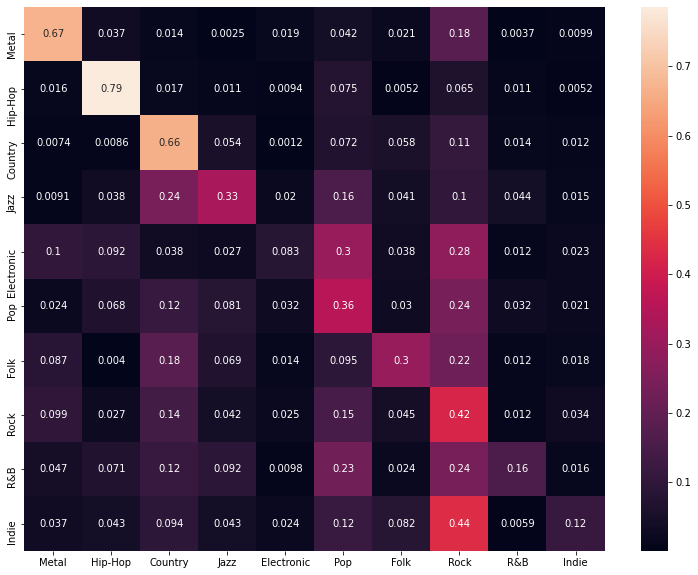

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, test_predictions, normalize='true')
df_cm = pd.DataFrame(conf_matrix, index=[i for i in range(10)], columns=[i for i in range(10)])

fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(df_cm, annot=True)
ax.set_xticklabels(['Metal', 'Hip-Hop', 'Country', 'Jazz', 'Electronic', 
                    'Pop', 'Folk', 'Rock', 'R&B', 'Indie'])
ax.set_yticklabels(['Metal', 'Hip-Hop', 'Country', 'Jazz', 'Electronic', 
                    'Pop', 'Folk', 'Rock', 'R&B', 'Indie'])

### XLM - RoBERTa

Achieved about 47% test accuracy on the original non-English data. The other datasets did not improve this result.

In [ ]:
MODEL_NAME = 'xlm-roberta-base'
VOCABULARY_PATH = 'https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model'

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_train_nen.csv')
df_test = pd.read_csv('/content/drive/MyDrive/AI Masters/IRTM/df_test_nen.csv')

df_train['Lyrics'] = df_train['Lyrics'].astype(str)
df_test['Lyrics'] = df_test['Lyrics'].astype(str)

df_train['Lyrics'] = df_train['Lyrics'].map(lambda x: ' '.join(x.split('\n')))
df_test['Lyrics'] = df_test['Lyrics'].map(lambda x: ' '.join(x.split('\n')))
uniques_map = {}
for value, key in list(zip(range(df_train['Genre'].unique().shape[0]), df_train['Genre'].unique())):
    uniques_map[key] = value

df_train['Genre'] = df_train['Genre'].map(uniques_map)
df_test['Genre'] = df_test['Genre'].map(uniques_map)

tokenizer = XLMRobertaTokenizerFast.from_pretrained(MODEL_NAME,
                                                    do_lower_case = False)

train_input_ids, train_attention_masks, train_labels = tokenize_data(tokenizer, df_train)
test_input_ids, test_attention_masks, test_labels = tokenize_data(tokenizer, df_test)

dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(len(test_dataset)))

16,661 training samples
1,852 validation samples
7,935 test samples


In [ ]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, 
                              sampler = RandomSampler(train_dataset), 
                              batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,
                                   sampler = SequentialSampler(val_dataset),  
                                   batch_size = batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels = 10,  
    output_attentions = False,
    output_hidden_states = False)

optimizer = AdamW(model.parameters(), lr = 1e-5)

model.cuda()

In [ ]:
model, training_stats = train_model(model, 
                                    train_dataloader, validation_dataloader,
                                    epochs=6, seed_val=42, model_name=MODEL_NAME + '-')

In [ ]:
model.load_state_dict(torch.load('/content/bert_nen_cased_0.7285879629629629'))

In [ ]:
from sklearn.metrics import accuracy_score

test_dataloader = DataLoader(test_dataset,
                             sampler = SequentialSampler(test_dataset), 
                             batch_size = 1)

model.eval()
test_predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  label_ids = b_labels.to('cpu').numpy()
  test_predictions.append(torch.argmax(logits).item())
  true_labels.append(label_ids)

accuracy_score(true_labels, test_predictions)

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, test_predictions, normalize='true')
df_cm = pd.DataFrame(conf_matrix, index=[i for i in range(10)], columns=[i for i in range(10)])

fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(df_cm, annot=True)
ax.set_xticklabels(['Metal', 'Hip-Hop', 'Country', 'Jazz', 'Electronic', 
                    'Pop', 'Folk', 'Rock', 'R&B', 'Indie'])
ax.set_yticklabels(['Metal', 'Hip-Hop', 'Country', 'Jazz', 'Electronic', 
                    'Pop', 'Folk', 'Rock', 'R&B', 'Indie'])

## BERT Language Model + Sequence Classification Model

Tried implementing the idea from this paper [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/abs/1905.05583). The authors propose finetuning a language model, loading the model's weights to a sequence classification model which is then finetunes.

Unfortunately I ran into techincal problems with the `PyTorch` BERT from HuggingFace's `transformers`. At the same time, I also ran out of time since my schedule started to become busy come finals. I decided to keep the code in case I or someone else needs this type of design.

In [ ]:
!pip install sentencepiece
!pip install transformers

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import DistilBertTokenizerFast, DistilBertForMaskedLM,  DistilBertForSequenceClassification
from transformers import XLMRobertaTokenizerFast, XLMRobertaForMaskedLM, XLMRobertaForSequenceClassification
from transformers import AdamW, get_cosine_schedule_with_warmup

torch.set_grad_enabled(True)
if torch.cuda.is_available(): 
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

MODEL_NAME = 'distilbert-base-cased-distilled-squad'

In [ ]:
def train_model_lm(model, train_dataloader, validation_dataloader, model_name,
                   epochs=10, seed_val=42, num_warmup_steps=0):
    training_stats = []

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    total_steps = len(train_dataloader) * epochs

    scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = num_warmup_steps,
                                                num_training_steps = total_steps)

    saved_model_accuracy = -1
    saved_model_loss = 1000
    best_acc = -1

    cross_entropy_loss = nn.CrossEntropyLoss()

    for epoch_i in range(0, epochs):
        total_train_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        
            output = model(b_input_ids, 
                           attention_mask=b_input_mask, 
                           labels=b_labels)
            loss, logits = output.loss, output.logits
            # loss = cross_entropy_loss(logits, b_labels)
            total_train_loss += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)

        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        for batch in validation_dataloader:

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            with torch.no_grad():        

                output = model(b_input_ids, 
                               attention_mask=b_input_mask,
                               labels=b_labels)
                loss, logits = output.loss, output.logits

            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += compute_accuracy(logits, label_ids)
            
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        print("Epoch {} / {}: Average training loss: {:.4f}, Validation Acc: {:.4f}, Validation Loss: {:.4f}.".
            format(epoch_i + 1, epochs, avg_train_loss, avg_val_accuracy, avg_val_loss))
        
        if saved_model_loss > (avg_val_loss - 0.001):
            fileList = glob.glob('/content/' + model_name + '*')
            if len(fileList) != 0:
                os.remove(fileList[0])
            torch.save(model.state_dict(), '/content/' + model_name + str(avg_val_accuracy))
            saved_model_accuracy = avg_val_accuracy
            saved_model_loss = avg_val_loss
            best_acc = avg_val_acc
        
        training_stats.append({'epoch': epoch_i + 1, 'Training Loss': avg_train_loss,
                               'Val Loss': avg_val_loss, 'Val Acc': avg_val_accuracy})
        
    return model, training_stats, best_acc

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def restructure_train_data(df, batch_size=128):
    df_new = pd.DataFrame(columns=['Genre', 'Lyrics'])
    for row in df.iterrows():
        lyrics_tokenized = (' '.join(row[1]['Lyrics'].split('\n'))).split()
        lyrics_batches = chunks(lyrics_tokenized, batch_size)
        for lyrics_batch in lyrics_batches:
            if len(lyrics_batch) > 30 and row[1]['Genre'] not in ['Country', 'Hip-Hop', 'Electronic']:
                #remove small samples but not from underrepresented data
                df_new = df_new.append({'Genre': row[1]['Genre'], 
                                        'Lyrics': ' '.join(lyrics_batch)}, 
                                    ignore_index=True)
    return df_new

def tokenize_data_lm(tokenizer, df):
    input_ids = []
    attention_masks = []
    labels = []
    indexed_tokens = []

    for index, row in df.iterrows():
        encoded_dict = tokenizer.encode_plus(row['Lyrics'], 
                                             add_special_tokens = True, 
                                             max_length = 128,
                                             padding = 'max_length',
                                             truncation=True,
                                             return_attention_mask = True,
                                             return_tensors = 'pt')
        label = tokenizer.encode_plus(row['Genre'], 
                                      add_special_tokens = True, 
                                      max_length = 128,
                                      padding = 'max_length',
                                      truncation=True,
                                      return_attention_mask = True,
                                      return_tensors = 'pt')['input_ids']
        
        input_ids.append(encoded_dict['input_ids']) 
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(torch.tensor(label))

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.cat(labels, dim=0)

    return input_ids, attention_masks, labels

def create_lm_data(df):
    df_lm = pd.DataFrame(columns=['Genre', 'Lyrics'])

    for row in df.iterrows():
        mask_position = random.randint(0, len(row[1]['Lyrics'].split()) - 1)
        new_text = ' '.join(['<mask>' if word == row[1]['Lyrics'].split()[mask_position] else word for word in row[1]['Lyrics'].split()])
        df_lm = df_lm.append({'Genre': row[1]['Lyrics'], 'Lyrics': new_text}, ignore_index=True)
    
    return df_lm

### Remodel Data for Masked Language Model and Train Model

In [ ]:
df_train = restructure_train_data(df_train)

df_lm = create_lm_data(df_train)

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

input_ids, attention_masks, labels = tokenize_data_lm(tokenizer, df_lm)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

13,494 training samples
1,500 validation samples


In [ ]:
batch_size =  64

train_dataloader = DataLoader(train_dataset, 
                              sampler = RandomSampler(train_dataset), 
                              batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,
                                   sampler = SequentialSampler(val_dataset),  
                                   batch_size = batch_size)

In [ ]:
model_lm = DistilBertForMaskedLM.from_pretrained(MODEL_NAME)

optimizer = AdamW(model.parameters(), lr = 1e-5)

model.cuda()

In [ ]:
trianing_results = train_model_lm(model_lm, 
                                  train_dataloader, validation_dataloader, 
                                  epochs=4, seed_val=42, model_name=MODEL_NAME+'-lm-')

model, training_stats, best_acc = training_results

### Load LM Weights to Sequence Classification Model and Finetune Model

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels = 10,  
    output_attentions = False,
    output_hidden_states = False)

optimizer = AdamW(model.parameters(), lr = 1e-5)

model.cuda()

model.load_state_dict(torch.load(MODEL_NAME + '-lm-' + best_acc)) # load LM weights

In [ ]:
uniques_map = {}
for value, key in list(zip(range(df_train['Genre'].unique().shape[0]), df_train['Genre'].unique())):
    uniques_map[key] = value

df_train['Genre'] = df_train['Genre'].map(uniques_map)
df_test['Genre'] = df_test['Genre'].map(uniques_map)

df_train['Genre'] = df_train['Genre'].astype(int)
df_test['Genre'] = df_test['Genre'].astype(int)

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME, 
                                                    do_lower_case = False)

train_input_ids, train_attention_masks, train_labels = tokenize_data(tokenizer, df_train)
test_input_ids, test_attention_masks, test_labels = tokenize_data(tokenizer, df_test)

dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(len(test_dataset)))

In [ ]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, 
                              sampler = RandomSampler(train_dataset), 
                              batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,
                                   sampler = SequentialSampler(val_dataset),  
                                   batch_size = batch_size)

In [ ]:
trianing_results = train_model(model_seqc, 
                               train_dataloader, validation_dataloader, 
                               epochs=4, seed_val=42, model_name=MODEL_NAME+'-')

model, training_stats, best_acc = training_results

In [ ]:
model_seqc.load_state_dict(torch.load(MODEL_NAME + '-' + best_acc))

In [ ]:
from sklearn.metrics import accuracy_score

test_dataloader = DataLoader(test_dataset,
                             sampler = SequentialSampler(test_dataset), 
                             batch_size = 1)

model_seqc.eval()
test_predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      outputs = model_seqc(b_input_ids, 
                           attention_mask=b_input_mask)

  logits = outputs[0]
  label_ids = b_labels.to('cpu').numpy()
  test_predictions.append(torch.argmax(logits).item())
  true_labels.append(label_ids)

accuracy_score(true_labels, test_predictions)

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, test_predictions, normalize='true')
df_cm = pd.DataFrame(conf_matrix, index=[i for i in range(10)], columns=[i for i in range(10)])

fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(df_cm, annot=True)
ax.set_xticklabels(['Metal', 'Hip-Hop', 'Country', 'Jazz', 'Electronic', 
                    'Pop', 'Folk', 'Rock', 'R&B', 'Indie'])
ax.set_yticklabels(['Metal', 'Hip-Hop', 'Country', 'Jazz', 'Electronic', 
                    'Pop', 'Folk', 'Rock', 'R&B', 'Indie'])

## Additional Ideas

These are just some extra ideas that went through my head. I did not have the time to test them out, so I don't expect to be graded on them. I want to write them down so I'll have them stored for future reference.

1. Append song metadata to the end of each lyrics string.
2. Try smarter splits for the hierarchical model.
3. Indirect genre classification by predicting artist instead and using a map from `Artists` to `Genres` to get the final result.
4. Topic modelling using Dynamic Topic Modelling.
5. Unsupervised heuristics based on word frequency and/or distributions.